In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")

### Basic cleaning before we start bivariate analysis

In [3]:
def convert_total_sqft(x):
    """
    Convert total_sqft string to float in square feet.
    Handles:
    - ranges "1200 - 1400" → average
    - units: Sq. Meter, Sq. Yards, Acres, Perch, Guntha, Cents, etc.
    Returns float or None (later to NaN)
    """
    if isinstance(x, float):  # already numeric
        return x
    
    x = str(x).strip()
    
    # Case 1: range like "1133 - 1384"
    if '-' in x:
        tokens = x.split('-')
        if len(tokens) == 2:
            try:
                return (float(tokens[0]) + float(tokens[1])) / 2
            except:
                return None
    
    # Case 2: single number with unit
    # Remove commas if any
    x = x.replace(',', '')
    
    # Common unit conversions (approximate standard factors)
    conversion_factors = {
        'sq. meter': 10.7639,       # 1 sq.m = 10.7639 sqft
        'sq. meter': 10.7639,
        'square meter': 10.7639,
        'sq.meter': 10.7639,
        'sq meter': 10.7639,
        
        'sq. yard': 9.0,            # 1 sq.yd = 9 sqft
        'sq.yard': 9.0,
        'square yard': 9.0,
        'sq yard': 9.0,
        
        'acre': 43560,              # 1 acre = 43560 sqft
        'acres': 43560,
        
        'perch': 272.25,            # 1 perch ≈ 272.25 sqft
        'guntha': 1089,             # 1 guntha = 1089 sqft
        'cents': 435.6,             # 1 cent = 435.6 sqft
        'ground': 2400,             # 1 ground ≈ 2400 sqft (South India)
    }
    
    for unit, factor in conversion_factors.items():
        if unit in x.lower():
            num_part = x.lower().replace(unit, '').strip()
            try:
                return float(num_part) * factor
            except:
                return None
    
    # Plain number (most common case)
    try:
        return float(x)
    except:
        return None

# Apply conversion
df['total_sqft_num'] = df['total_sqft'].apply(convert_total_sqft)

# Drop original and rows where conversion failed
df = df.dropna(subset=['total_sqft_num'])
df = df.drop(columns=['total_sqft'])
df = df.rename(columns={'total_sqft_num': 'total_sqft'})

print("After total_sqft cleaning:", df.shape)

After total_sqft cleaning: (13296, 9)


In [4]:
df.head()

,area_type,availability,location,size,society,bath,balcony,price,total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,2.0,1.0,39.07,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,5.0,3.0,120.00,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,2.0,3.0,62.00,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,3.0,1.0,95.00,1521.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,2.0,1.0,51.00,1200.0


In [8]:
def extract_bhk(x):
    if pd.isna(x):
        return np.nan
    try:
        # Take first token: "2 BHK" → 2, "4 Bedroom" → 4
        return int(x.split()[0])
    except:
        return np.nan

In [9]:
df['bhk'] = df['size'].apply(extract_bhk)

In [10]:
df = df.dropna(subset=['bhk'])
print("After bhk extraction:", df.shape)

After bhk extraction: (13280, 10)


In [11]:
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

In [12]:
df['bath'] = df['bath'].fillna(df['bath'].median())
df['balcony'] = df['balcony'].fillna(df['balcony'].median())

In [13]:
df = df[df['bath'] <= 10]

In [14]:
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 area_type            0
availability         0
location             1
size                 0
society           5466
bath                 0
balcony              0
price                0
total_sqft           0
bhk                  0
price_per_sqft       0
dtype: int64


In [15]:
df.head()

,area_type,availability,location,size,society,bath,balcony,price,total_sqft,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,2.0,1.0,39.07,1056.0,2.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,5.0,3.0,120.00,2600.0,4.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,2.0,3.0,62.00,1440.0,3.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,3.0,1.0,95.00,1521.0,3.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,2.0,1.0,51.00,1200.0,2.0,4250.000000


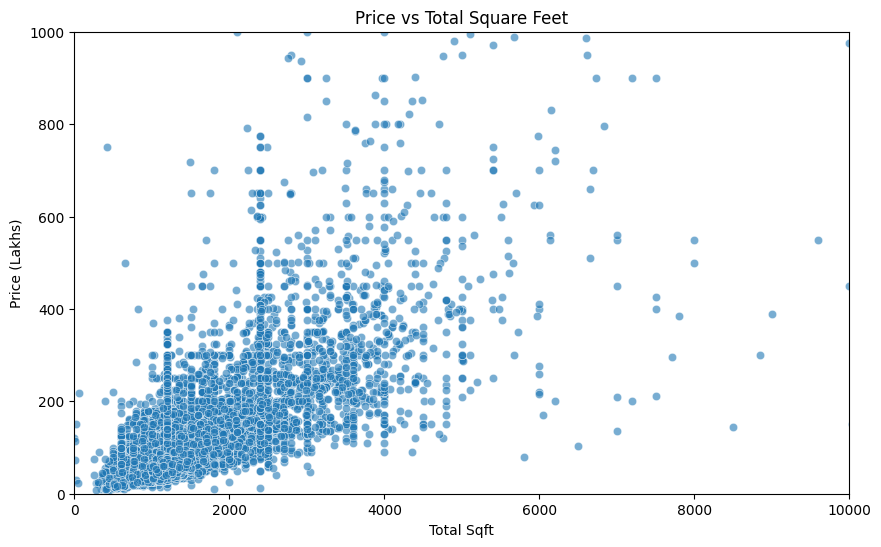

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='total_sqft', y='price', data=df, alpha=0.6)
plt.title("Price vs Total Square Feet")
plt.xlabel("Total Sqft")
plt.ylabel("Price (Lakhs)")
plt.xlim(0, 10000)   # zoom to remove extreme outliers
plt.ylim(0, 1000)
plt.show()

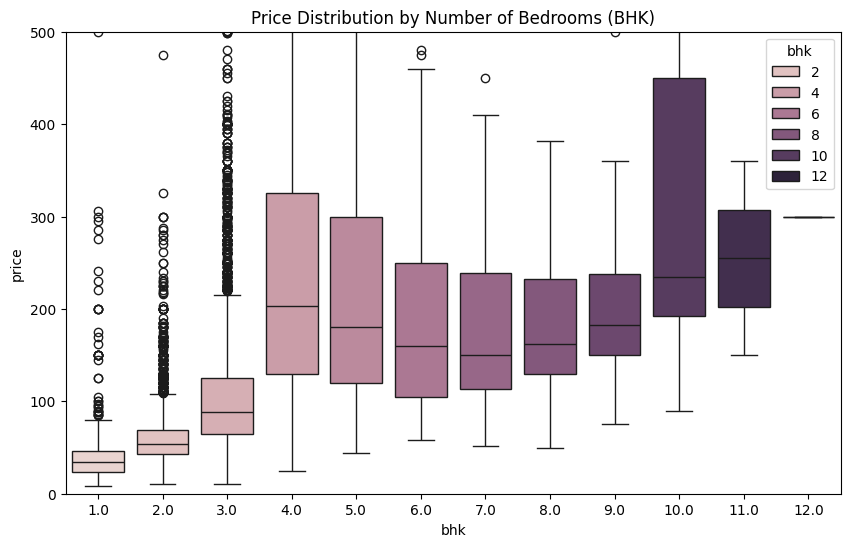

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x='bhk', y='price', data=df, hue = 'bhk')
plt.title("Price Distribution by Number of Bedrooms (BHK)")
plt.ylim(0, 500)  # zoom
plt.show()

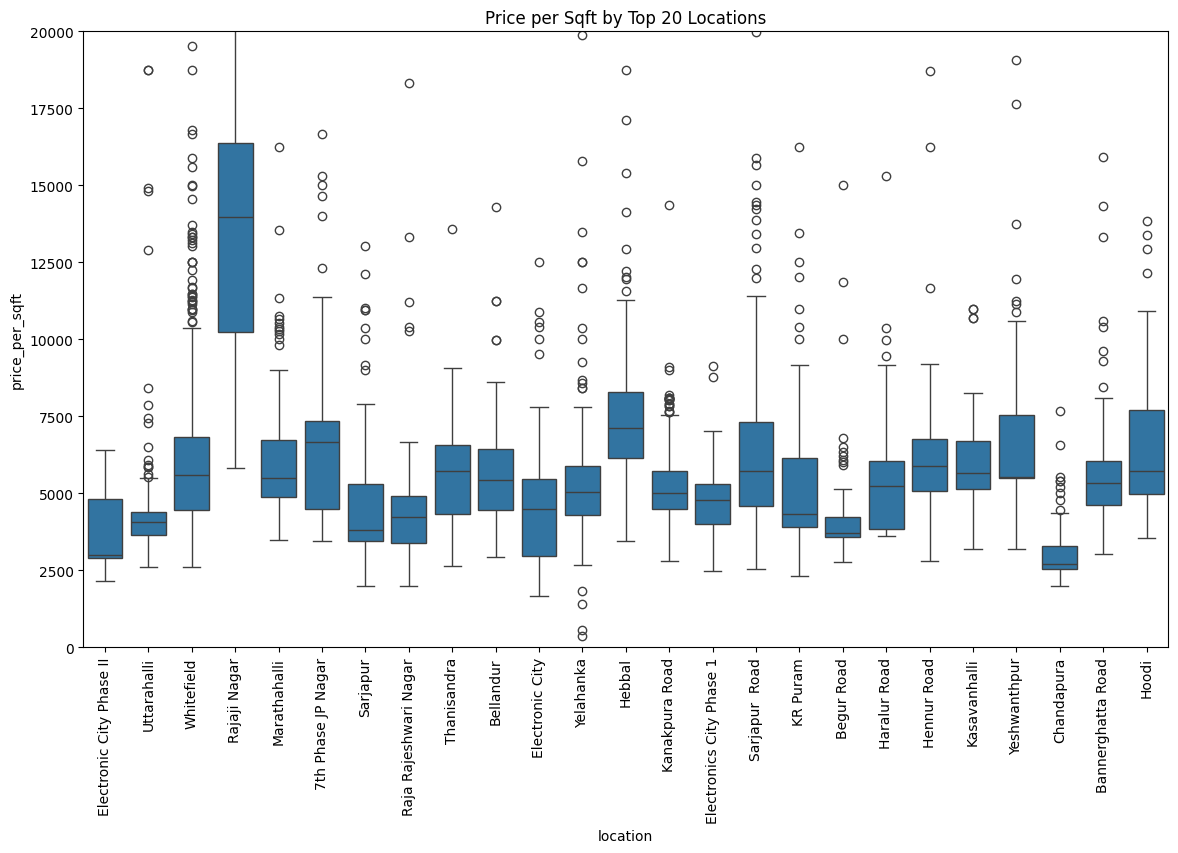

In [22]:
top_locations = df['location'].value_counts().head(25).index

plt.figure(figsize=(14,8))
sns.boxplot(x='location', y='price_per_sqft', data=df[df['location'].isin(top_locations)])
plt.xticks(rotation=90)
plt.title("Price per Sqft by Top 20 Locations")
plt.ylim(0, 20000)  # zoom to see pattern
plt.show()

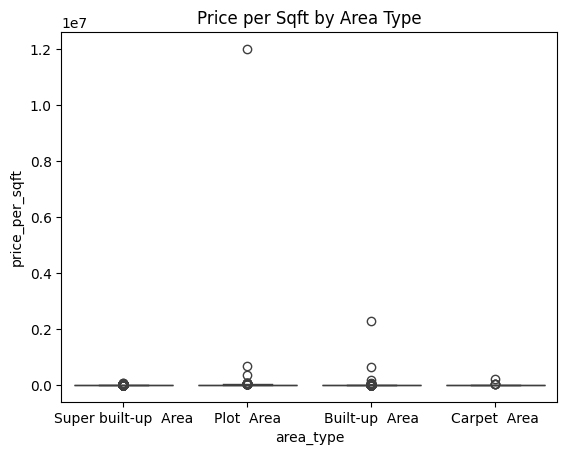

In [20]:
fig, ax = plt.subplots()
sns.boxplot(x='area_type', y='price_per_sqft', data=df)
plt.title("Price per Sqft by Area Type")
plt.show()

In [23]:
print("Value counts of area_type:")
print(df['area_type'].value_counts())

Value counts of area_type:
area_type
Super built-up  Area    8780
Built-up  Area          2409
Plot  Area              1984
Carpet  Area              87
Name: count, dtype: int64


In [27]:
print("\nPrice per sqft descriptive statistics by area_type:")
print(
    df.groupby('area_type')['price_per_sqft']
      .describe()
      .round(1)
      .sort_values('50%', ascending=False)   # sorted by median
)


Price per sqft descriptive statistics by area_type:
                       count     mean       std     min     25%      50%  \
area_type                                                                  
Plot  Area            1984.0  18268.8  269738.2    44.4  6723.3  10625.0   
Carpet  Area            87.0   9202.5   21251.6  2826.1  4834.6   6034.3   
Super built-up  Area  8780.0   5688.4    2693.5   405.4  4114.5   5121.2   
Built-up  Area        2409.0   7359.9   48668.2    23.6  4170.2   5114.3   

                          75%         max  
area_type                                  
Plot  Area            15000.0  12000000.0  
Carpet  Area           8334.0    200000.0  
Super built-up  Area   6492.9     56000.0  
Built-up  Area         6800.0   2300000.0  


In [28]:
summary = df.groupby('area_type')['price_per_sqft'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(1).sort_values('median', ascending=False)

In [29]:
print("\nSummary (sorted by median price_per_sqft):")
print(summary)


Summary (sorted by median price_per_sqft):
                      count     mean   median       std     min         max
area_type                                                                  
Plot  Area             1984  18268.8  10625.0  269738.2    44.4  12000000.0
Carpet  Area             87   9202.5   6034.3   21251.6  2826.1    200000.0
Super built-up  Area   8780   5688.4   5121.2    2693.5   405.4     56000.0
Built-up  Area         2409   7359.9   5114.3   48668.2    23.6   2300000.0


In [36]:
df.groupby(['society']).agg(total_count = ('society', 'count'),median_price = ('price', 'median')).sort_values(['total_count'], ascending = False)

,total_count,median_price
society,,
GrrvaGr,80,48.7450
PrarePa,76,41.0725
Sryalan,59,33.5000
Prtates,58,89.4100
GMown E,56,55.0000
...,...,...
Jalonht,1,210.0000
Jalot C,1,195.0000
Janaala,1,150.0000


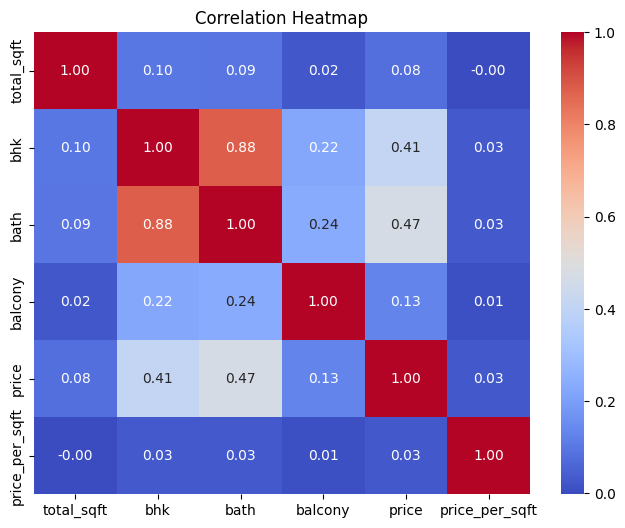

In [21]:
numeric_df = df[['total_sqft', 'bhk', 'bath', 'balcony', 'price', 'price_per_sqft']]
corr = numeric_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## 📊 Bivariate Analysis Insights

### Location
- **Observation**: Location outperforms size, BHK, or bath in explaining price variation.  
- **Action**: Group rare locations into an "Other" category and encode them properly (e.g., one-hot or target encoding) to improve model performance.

### Price vs Total Square Feet
- **Observation**: Scatter plot shows a clear positive trend — larger homes cost more.  
- **Action**: Retain `total_sqft` as a key predictor; consider normalizing or scaling for modeling.

### BHK and Bathrooms
- **Observation**: Both features are useful but somewhat redundant; their effect is secondary compared to location and sqft.  
- **Action**: Keep one (usually BHK) or engineer a combined feature (e.g., `rooms_per_bath`) to reduce redundancy.

### Area Type
- **Observation**: Area type has a statistically visible effect on `price_per_sqft`, even after controlling for size.  
- **Action**: Encode area type (e.g., one-hot encoding) to capture its influence in the model.
